In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 0 2 0 0 0 1 0 0 0 0 1 0 1 2 1 0 0 0 1 1 0 1 0 0 1 2 1 2 1 0 1]


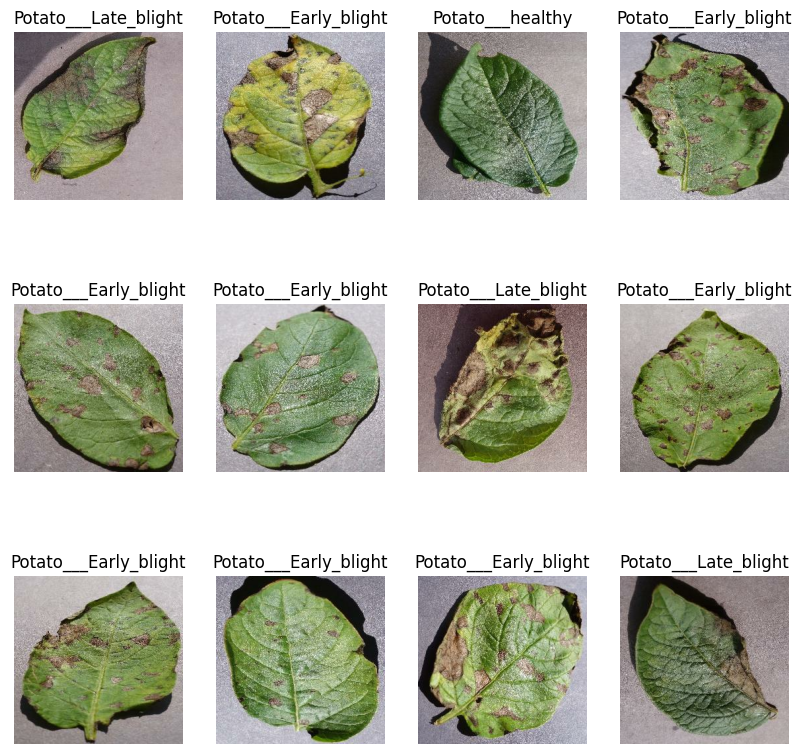

In [5]:
plt.figure(figsize=(10,10))

for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


#### Training and Testing data split
##### 80% ==> Training 
##### 10% ==> Validation
##### 10% ==> Test

In [6]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [7]:
train_ds = dataset.take(54)
len(train_ds)

54

In [8]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [9]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [10]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [11]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [12]:
def get_dataset_partions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    assert(train_split + val_split + test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [13]:
train_ds, val_ds, test_ds = get_dataset_partions_tf(dataset)

In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [18]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.67058825 0.6431373  0.67058825]
  [0.6745098  0.64705884 0.6745098 ]
  [0.68235296 0.654902   0.68235296]
  ...
  [0.73333335 0.72156864 0.7647059 ]
  [0.70980394 0.69803923 0.7411765 ]
  [0.6901961  0.6784314  0.72156864]]

 [[0.67058825 0.6431373  0.67058825]
  [0.6784314  0.6509804  0.6784314 ]
  [0.68235296 0.654902   0.68235296]
  ...
  [0.7137255  0.7019608  0.74509805]
  [0.7019608  0.6901961  0.73333335]
  [0.6901961  0.6784314  0.72156864]]

 [[0.6745098  0.64705884 0.6745098 ]
  [0.6784314  0.6509804  0.6784314 ]
  [0.6784314  0.6509804  0.6784314 ]
  ...
  [0.69803923 0.6862745  0.7294118 ]
  [0.69803923 0.6862745  0.7294118 ]
  [0.7019608  0.6901961  0.73333335]]

 ...

 [[0.34901962 0.29803923 0.33333334]
  [0.3764706  0.3254902  0.36078432]
  [0.38039216 0.32941177 0.3647059 ]
  ...
  [0.45490196 0.41568628 0.45882353]
  [0.44313726 0.40392157 0.44705883]
  [0.4392157  0.4        0.44313726]]

 [[0.44705883 0.39607844 0.43137255]
  [0.45882353 0.40784314 0.44313726]


In [27]:
resize_and_rescale = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1.0/255)
    ]
)

In [28]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)

#### Creating Model (Architecture)

In [35]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(n_classes, activation = 'softmax'), 
    ]
)

model.build(input_shape=input_shape)

In [36]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [37]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [38]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

Epoch 1/50
54/54 [==============================] - 90s 2s/step - loss: 0.9319 - accuracy: 0.4954 - val_loss: 0.8653 - val_accuracy: 0.5469
Epoch 2/50
54/54 [==============================] - 80s 1s/step - loss: 0.7483 - accuracy: 0.6644 - val_loss: 0.6295 - val_accuracy: 0.7240
Epoch 3/50
54/54 [==============================] - 80s 1s/step - loss: 0.4706 - accuracy: 0.8108 - val_loss: 0.3938 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 88s 2s/step - loss: 0.3474 - accuracy: 0.8617 - val_loss: 0.3592 - val_accuracy: 0.8542
Epoch 5/50
54/54 [==============================] - 92s 2s/step - loss: 0.2891 - accuracy: 0.8889 - val_loss: 0.2316 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 96s 2s/step - loss: 0.2270 - accuracy: 0.9115 - val_loss: 0.2557 - val_accuracy: 0.8958
Epoch 7/50
54/54 [==============================] - 90s 2s/step - loss: 0.2379 - accuracy: 0.9074 - val_loss: 0.1989 - val_accuracy: 0.9219
Epoch 8/50
54/54 [==

In [39]:
len(test_ds)

8

In [40]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 292ms/step - loss: 0.0179 - accuracy: 0.9961


In [41]:
scores

[0.01790948025882244, 0.99609375]

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#### Ploting the Graph

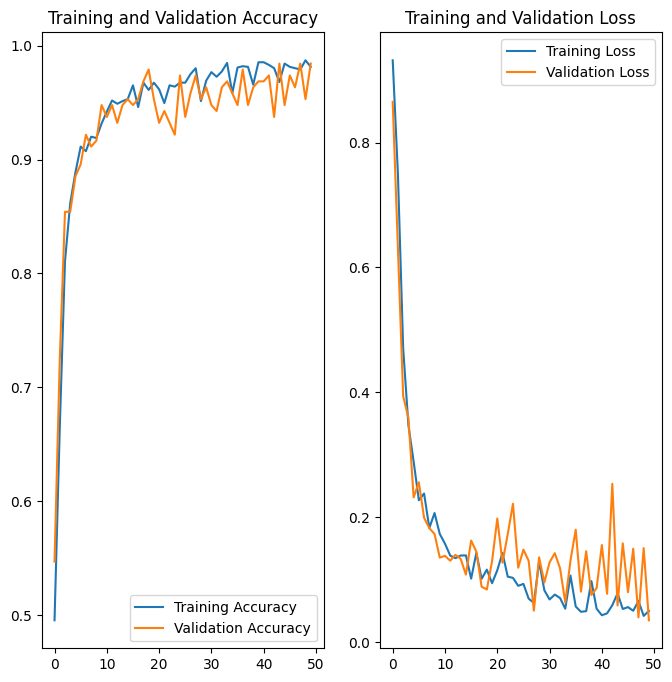

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label: Potato___Early_blight
1/1 [==============================] - 0s 275ms/step
Predicted Label: Potato___Early_blight


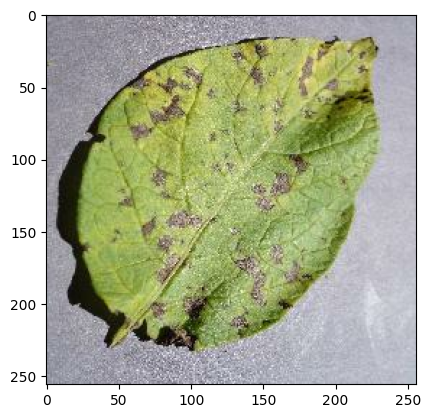

In [69]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])

    batch_prediction = model.predict(image_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])


In [70]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


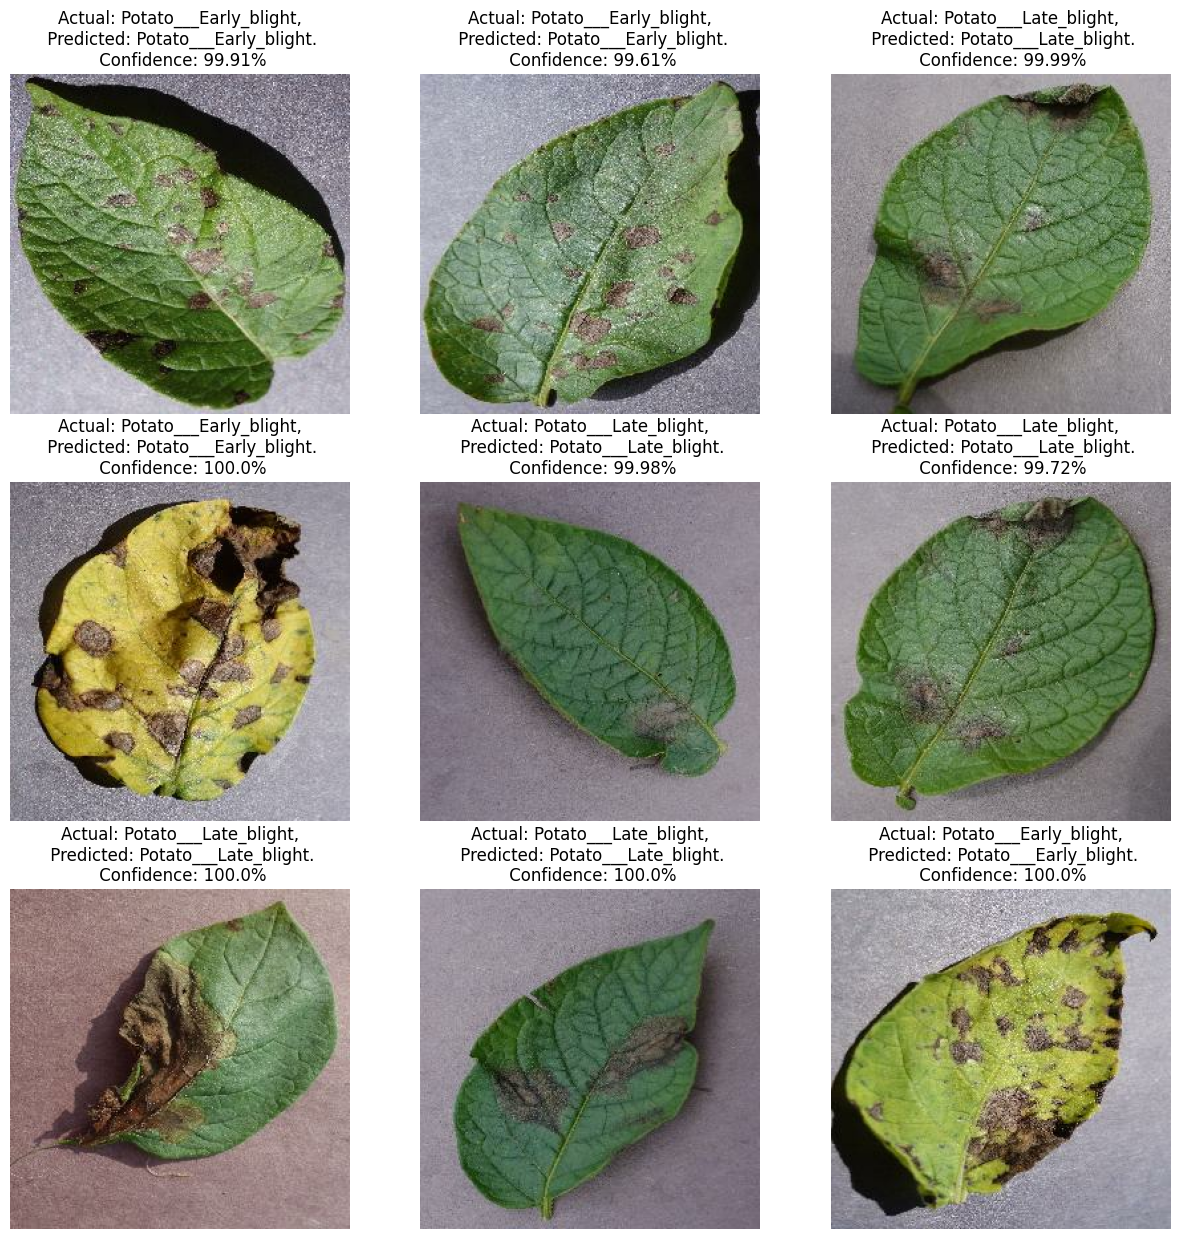

In [72]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())

        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [73]:
model_version = 1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets
